## Datasets Extraction

In [ ]:
import pandas as pd



file_path = "OECD_all.xlsx"

excel_file = pd.ExcelFile(file_path)
print(excel_file.sheet_names)

We now extract all the datasets from the Excel downloaded from the official OECD page (https://www.oecd.org/en/data/tools/oecd-regional-well-being.html).

In [ ]:
import pandas as pd



file_path = "OECD_all.xlsx"
output_file = "Score_Last_Region.csv"

def load_score_last(path, sheet="Score_Last", col_range="B:O"):
    return pd.read_excel(
        path,
        sheet_name=sheet,
        usecols=col_range,
        header=6,       
        skiprows=[7],   
        nrows=447       
    )

df_score_last = load_score_last(file_path)

print(df_score_last.head())
print(df_score_last.tail())

df_score_last.to_csv(output_file, index=False)
print(f"\nSaved cleaned data to: {output_file}")

In [ ]:
import pandas as pd



df_raw = pd.read_excel(file_path, sheet_name="Score_Last", header=None)

df_subset = df_raw.iloc[458:496, 2:18].reset_index(drop=True)

new_columns = df_score_last.columns.tolist()
new_columns.pop(1)  

df_subset.columns = new_columns

output_file = "Score_Last_Country.csv"
df_subset.to_csv(output_file, index=False)

print(df_subset.head())
print(df_subset.tail())

print(f"Saved to {output_file}")

In [ ]:
import pandas as pd



file_path = "OECD_all.xlsx"
output_file = "Indicator_Last_Region.csv"

def load_indicator_last(path, sheet="Indicator_Last", col_range="B:R"):
    return pd.read_excel(
        path,
        sheet_name=sheet,
        usecols=col_range,
        header=6,       
        skiprows=[7],   
        nrows=447       
    )

df_indicator_last = load_indicator_last(file_path)

suffixes_str = "%, %, %, constant USD PPP (refer. year 2015), per 100-000 people, per 1-000 people, Number of years, µg/m³, %, % of households, deviation from OECD average (%), rooms per person, %, index 0 to 10"

suffixes = [s.strip() for s in suffixes_str.split(',')]

for i, suffix in enumerate(suffixes):
    col_index = 3 + i
    if col_index < len(df_score_last.columns):
        df_indicator_last.columns.values[col_index] = f"{df_indicator_last.columns[col_index]} ({suffix})"

print(df_indicator_last.head())
print(df_indicator_last.tail())

df_indicator_last.to_csv(output_file, index=False)
print(f"\nSaved cleaned data to: {output_file}")

In [ ]:
import pandas as pd



df_raw = pd.read_excel(file_path, sheet_name="Indicator_Last", header=None)

df_subset = df_raw.iloc[458:496, 2:18].reset_index(drop=True)

new_columns = df_indicator_last.columns.tolist()
new_columns.pop(1)  

df_subset.columns = new_columns

output_file = "Indicator_Last_Country.csv"
df_subset.to_csv(output_file, index=False)

print(df_subset.head())
print(df_subset.tail())

print(f"Saved to {output_file}")

In [ ]:
import pandas as pd



file_path = "OECD_all.xlsx"
output_file = "Score_Trend_Region.csv"

def load_score_trend(path, sheet="Score_Trend", col_range="B:O"):
    return pd.read_excel(
        path,
        sheet_name=sheet,
        usecols=col_range,
        header=6,       
        skiprows=[7],   
        nrows=447       
    )

df_score_trend = load_score_trend(file_path)

print(df_score_trend.head())
print(df_score_trend.tail())

df_score_trend.to_csv(output_file, index=False)
print(f"\nSaved cleaned data to: {output_file}")

We now have saved five datasets: two for the scores (regions and country), two for the indicators (regions and country) and one for the trends.
Note that for this part we will only use regions scores and indicators datasets. Their paths are defined below


## Impute NaN values

In [ ]:
files = {
    "Indicator_Last_Region": "Indicator_Last_Region.csv",
    "Score_Last_Region": "Score_Last_Region.csv",
}

We now use KNN imputation to fill NaN values (that in the datasets are indicated with ".."). In this case, since our aim is to predict a variable ("Life satisfaction" and "Self assessment of life satisfaction") we don't impute that one to make sure our models are as reliable as we can.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer



for name, path in files.items():

    df = pd.read_csv(path, na_values=[".."])

    num_cols = df.select_dtypes(include=[np.number]).columns

    target_col = "Life satisfaction"
    target_col2 = "Self assessment of life satisfaction"
    feature_cols = [col for col in num_cols if col not in [target_col, target_col2]]

    if feature_cols:  
        knn_imp = KNNImputer(n_neighbors=5)
        df[feature_cols] = knn_imp.fit_transform(df[feature_cols])

    df.to_csv(path, index=False)
    print(f"{name}: imputation complete and saved → {path}")

## Import datasets

In [6]:
files = {
    "Indicator_Last_Region": "Indicator_Last_Region.csv",
    "Score_Last_Region": "Score_Last_Region.csv",
}

In [8]:
import pandas as pd
import numpy as np



datasets = {
    name: pd.read_csv(path)
    for name, path in files.items()
}

# Score Dataset

In [57]:
df_score = datasets["Score_Last_Region"]

## NaN values handling

We drop rows with NaN target variable and exclude categorical raws from the features (countries, regions and their codes).

In [61]:
import pandas as pd



initial_rows = len(df_score)

df_score = df_score.dropna(subset=["Life satisfaction"])

dropped_rows = initial_rows - len(df_score)
print(f"Rows dropped due to missing 'Life satisfaction': {dropped_rows}")

columns_to_exclude = ["Country", "Region", "Code", "Life satisfaction"]
X_score = df_score.drop(columns=columns_to_exclude, errors="ignore")
y_score = df_score["Life satisfaction"]

Rows dropped due to missing 'Life satisfaction': 10


## Train and Test split

In [64]:
from sklearn.model_selection import train_test_split



X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    X_score, y_score, test_size=0.2, random_state=1748
)

test_indices = y_test_score.index

## Hyperparameters Tuning

We perform some model tuning. first with a quite wide range to see which hyperparameters are better for our two models of choice, XGBoost and Random Forest.

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error



models = {
    "Random Forest": RandomForestRegressor(random_state=1748, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=1748, n_jobs=-1, objective="reg:squarederror"),
}

param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300, 400, 500],          
        "max_depth": [None, 10, 20, 30, 40],                
        "min_samples_split": [2, 5, 10],                     
        "min_samples_leaf": [1, 2, 4],                       
        "bootstrap": [True, False]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300, 400, 500],          
        "max_depth": [3, 4, 5, 6],                           
        "learning_rate": [0.01, 0.03, 0.05, 0.1],            
        "subsample": [0.5, 0.7, 0.8, 1.0],                   
        "colsample_bytree": [0.5, 0.7, 0.8, 1.0],
        "gamma": [0, 0.1, 0.2, 0.5]                          
    }
}

best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        model,
        param_grid=param_grids[name],
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )
    grid_search.fit(X_train_score, y_train_score)
    best_models[name] = grid_search.best_estimator_

    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best CV RMSE: {-grid_search.best_score_:.3f}")

for name, model in best_models.items():
    y_pred_score = model.predict(X_test_score)
    test_rmse = root_mean_squared_error(y_test_score, y_pred_score)
    print(f"{name} Test RMSE: {test_rmse:.3f}")


As a result we have that: 

-------------------------------------------------------------------------------------------------------------------------------------------------
Best params for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best CV RMSE: 1.454

-------------------------------------------------------------------------------------------------------------------------------------------------
           
Best params for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.5}

Best CV RMSE: 1.431

-------------------------------------------------------------------------------------------------------------------------------------------------

Random Forest Test RMSE: 1.354

XGBoost Test RMSE: 1.280

We now do some fine tuning by narrowing the intervals of our search to values nearby the past results.

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error



models = {
    "Random Forest": RandomForestRegressor(random_state=1748, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=1748, n_jobs=-1, objective="reg:squarederror"),
}


param_grids = {
    "Random Forest": {
        "n_estimators": [90, 95, 100, 105, 110],            
        "max_depth": [None],                    
        "min_samples_split": [2, 3],                        
        "min_samples_leaf": [1, 2],                        
        "bootstrap": [True]                                 
    },
    "XGBoost": {
        "n_estimators": [290, 295, 300, 305, 310],          
        "max_depth": [5, 6, 7],                             
        "learning_rate": [0.04, 0.05, 0.06],                
        "subsample": [0.45, 0.5, 0.55],                     
        "colsample_bytree": [0.75, 0.8, 0.85],              
        "gamma": [0.05, 0.1, 0.15]                          
    }
}

best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        model,
        param_grid=param_grids[name],
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )
    grid_search.fit(X_train_score, y_train_score)
    best_models[name] = grid_search.best_estimator_

    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best CV RMSE: {-grid_search.best_score_:.3f}")

for name, model in best_models.items():
    y_pred_score = model.predict(X_test_score)
    test_rmse = root_mean_squared_error(y_test_score, y_pred_score)
    print(f"{name} Test RMSE: {test_rmse:.3f}")


As a result we have that: 

-------------------------------------------------------------------------------------------------------------------------------------------------
Best params for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 110}

Best CV RMSE: 1.451


-------------------------------------------------------------------------------------------------------------------------------------------------
Best params for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 305, 'subsample': 0.5}

Best CV RMSE: 1.431


-------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest Test RMSE: 1.353

XGBoost Test RMSE: 1.280

## Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor

rf_model_score = RandomForestRegressor(
    n_estimators=110,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=1748,
    n_jobs=-1
)

rf_model_score.fit(X_train_score, y_train_score)

RandomForestRegressor(min_samples_split=3, n_estimators=110, n_jobs=-1,
                      random_state=1748)

## XGBoost

In [71]:
from xgboost import XGBRegressor



xgb_model_score = XGBRegressor(
    n_estimators=305,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=0.8,
    gamma=0.1,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=1748
)

xgb_model_score.fit(X_train_score, y_train_score)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=305,
             n_jobs=-1, num_parallel_tree=None, ...)

## T-test

In [74]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, make_scorer
from scipy.stats import ttest_rel
import numpy as np



rmse_scorer = make_scorer(root_mean_squared_error)

cv = KFold(n_splits=5, shuffle=True, random_state=1748)

xgb_scores = cross_val_score(xgb_model_score, X_train_score, y_train_score, scoring=rmse_scorer, cv=cv)
rf_scores = cross_val_score(rf_model_score, X_train_score, y_train_score, scoring=rmse_scorer, cv=cv)

print("Cross-validated RMSE:")
print(f"XGBoost: Mean = {xgb_scores.mean():.4f}, Std = {xgb_scores.std():.4f}")
print(f"Random Forest: Mean = {rf_scores.mean():.4f}, Std = {rf_scores.std():.4f}")

# Paired t-test
t_stat, p_value = ttest_rel(xgb_scores, rf_scores)
print("\nPaired t-test between XGBoost and Random Forest RMSE:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    better = "XGBoost" if xgb_scores.mean() < rf_scores.mean() else "Random Forest"
    print(f"The difference is statistically significant. {better} performs better.")
else:
    print("No statistically significant difference found.")

Cross-validated RMSE:
XGBoost: Mean = 1.5514, Std = 0.0998
Random Forest: Mean = 1.4653, Std = 0.0693

Paired t-test between XGBoost and Random Forest RMSE:
t-statistic = 4.1648, p-value = 0.0141
The difference is statistically significant. Random Forest performs better.


Cross-validated RMSE:

XGBoost: Mean = 1.5514, Std = 0.0998

Random Forest: Mean = 1.4653, Std = 0.0693

---------------------------------------------------------------------------

Paired t-test between XGBoost and Random Forest RMSE:

t-statistic = 4.1648, p-value = 0.0141

---------------------------------------------------------------------------
The difference is statistically significant. Random Forest performs better.


In [548]:
mae_scorer = make_scorer(mean_absolute_error)
xgb_mae = cross_val_score(xgb_model_score, X_train_score, y_train_score, scoring=mae_scorer, cv=cv)
rf_mae = cross_val_score(rf_model_score, X_train_score, y_train_score, scoring=mae_scorer, cv=cv)

print("Cross-validated MAE:")
print(f"XGBoost: Mean = {xgb_mae.mean():.4f}, Std = {xgb_mae.std():.4f}")
print(f"Random Forest: Mean = {rf_mae.mean():.4f}, Std = {rf_mae.std():.4f}")

t_stat_mae, p_value_mae = ttest_rel(xgb_mae, rf_mae)
print("\nPaired t-test between XGBoost and Random Forest MAE:")
print(f"t-statistic = {t_stat_mae:.4f}, p-value = {p_value_mae:.4f}")
if p_value_mae < 0.05:
    better = "XGBoost" if xgb_mae.mean() < rf_mae.mean() else "Random Forest"
    print(f"The difference is statistically significant. {better} performs better.")
else:
    print("No statistically significant difference found.")

Cross-validated MAE:
XGBoost: Mean = 1.1743, Std = 0.0509
Random Forest: Mean = 1.0963, Std = 0.0726

Paired t-test between XGBoost and Random Forest MAE:
t-statistic = 5.8103, p-value = 0.0044
The difference is statistically significant. Random Forest performs better.


Cross-validated MAE:

----------------------------------------------------------------------------------
XGBoost: Mean = 1.1743, Std = 0.0509

Random Forest: Mean = 1.0963, Std = 0.0726

----------------------------------------------------------------------------------
Paired t-test between XGBoost and Random Forest MAE:

t-statistic = 5.8103, p-value = 0.0044

----------------------------------------------------------------------------------
The difference is statistically significant. Random Forest performs better.

In [550]:
r2_scorer = make_scorer(r2_score)
xgb_r2 = cross_val_score(xgb_model_score, X_train_score, y_train_score, scoring=r2_scorer, cv=cv)
rf_r2 = cross_val_score(rf_model_score, X_train_score, y_train_score, scoring=r2_scorer, cv=cv)

print("\nCross-validated R²:")
print(f"XGBoost: Mean = {xgb_r2.mean():.4f}, Std = {xgb_r2.std():.4f}")
print(f"Random Forest: Mean = {rf_r2.mean():.4f}, Std = {rf_r2.std():.4f}")

t_stat_r2, p_value_r2 = ttest_rel(xgb_r2, rf_r2)
print("\nPaired t-test between XGBoost and Random Forest R²:")
print(f"t-statistic = {t_stat_r2:.4f}, p-value = {p_value_r2:.4f}")
if p_value_r2 < 0.05:
    better = "XGBoost" if xgb_r2.mean() > rf_r2.mean() else "Random Forest"
    print(f"The difference is statistically significant. {better} performs better.")
else:
    print("No statistically significant difference found.")


Cross-validated R²:
XGBoost: Mean = 0.6636, Std = 0.0586
Random Forest: Mean = 0.7004, Std = 0.0473

Paired t-test between XGBoost and Random Forest R²:
t-statistic = -4.0960, p-value = 0.0149
The difference is statistically significant. Random Forest performs better.


Cross-validated R²:

----------------------------------------------------------------------------------
XGBoost: Mean = 0.6636, Std = 0.0586

Random Forest: Mean = 0.7004, Std = 0.0473

----------------------------------------------------------------------------------
Paired t-test between XGBoost and Random Forest R²:

t-statistic = -4.0960, p-value = 0.0149

----------------------------------------------------------------------------------
The difference is statistically significant. Random Forest performs better.

Since all of our three indexes of goodness saw random forest perform better than XGBoost, we will analyse that model to better undertsand its functioning.

## Plotting the predictions

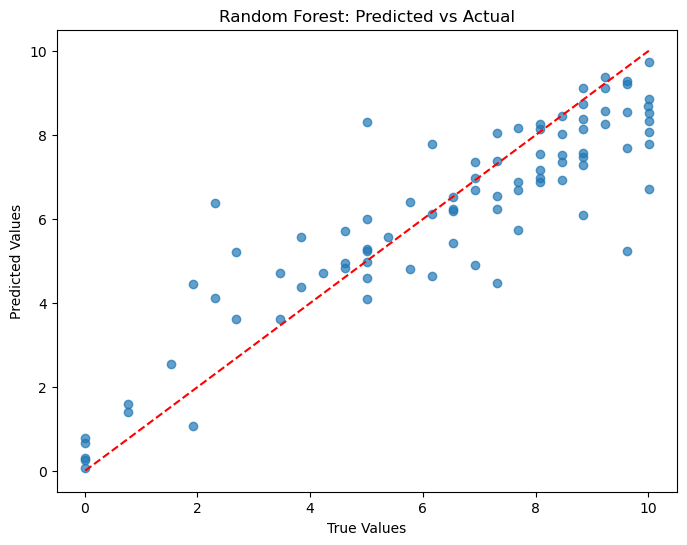

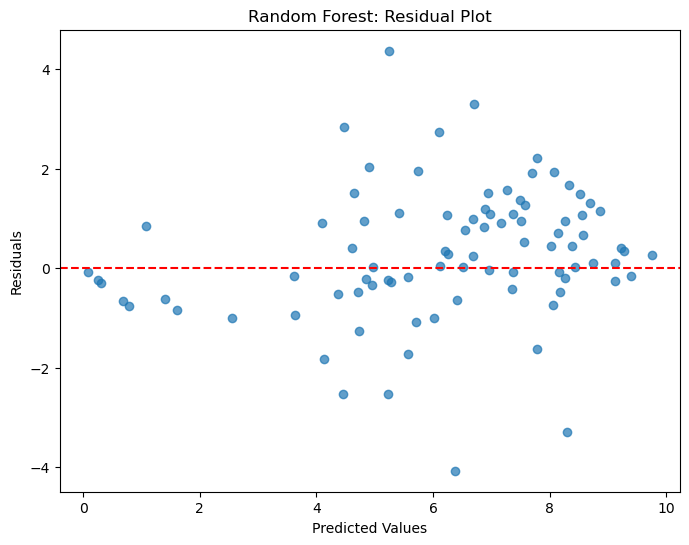

In [271]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, model_name, data, original_indices):
    residuals = y_true - y_pred
    threshold = residuals.abs().mean() + 2 * residuals.abs().std()
    outliers_idx = residuals[residuals.abs() > threshold].index
    outlier_scores = residuals.loc[outliers_idx]

    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.show()

    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"{model_name}: Residual Plot")
    plt.show()
    
    return outlier_scores

rf_preds = rf_model_score.predict(X_test_score)
outlier_residuals = plot_predictions(
    y_true=y_test_score.reset_index(drop=True), 
    y_pred=rf_preds, 
    model_name="Random Forest", 
    data=df_score, 
    original_indices=test_indices
)

Residuals Summary Statistics:
count    88.000000
mean      0.275532
std       1.332383
min      -4.076716
25%      -0.358165
50%       0.248726
75%       1.072673
max       4.374766
Name: Life satisfaction, dtype: float64


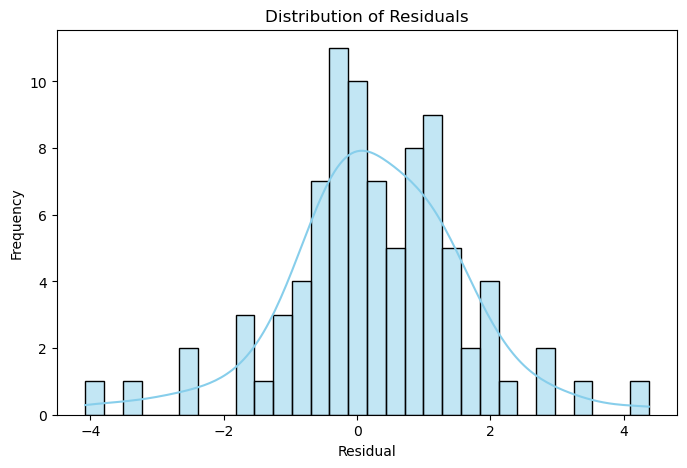

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def residuals_analysis(y_true, y_pred, data=None):
    residuals = y_true - y_pred
    
    # Basic stats
    print("Residuals Summary Statistics:")
    print(residuals.describe())
    
    # Histogram of residuals
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, bins=30, kde=True, color='skyblue')
    plt.title("Distribution of Residuals")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()


# Example usage
residuals_analysis(y_test_score.reset_index(drop=True), rf_preds, data=df_score)


The residuals have a small positive mean (~0.28), indicating a slight overall overprediction. The standard deviation (~1.33) shows some variability in errors. Residuals range from about -4.08 to 4.37, meaning some predictions are off by quite a bit, but the median residual is close to zero (~0.25), suggesting errors are generally balanced. The interquartile range indicates most errors fall between -0.36 and 1.07, with a few notable outliers on both ends.

## SHAP analysis

### SHAP Table and Bar Chart

In [112]:
import shap
import pandas as pd



rf_explainer_score = shap.TreeExplainer(rf_model_score)
shap_values_score = rf_explainer_score.shap_values(X_train_score)

shap_df_score = pd.DataFrame(shap_values_score, columns=X_train_score.columns)
shap_summary_score = shap_df_score.abs().mean()

shap_table_score = shap_summary_score.to_frame(name="SHAP Mean")
shap_table_score["Rank"] = shap_table_score["SHAP Mean"].rank(ascending=False).astype(int)
shap_table_score = shap_table_score.sort_values("Rank")

pd.set_option("display.max_rows", None)
print("SHAP Mean Absolute Values with Rankings:\n")
print(shap_table_score)

SHAP Mean Absolute Values with Rankings:

                          SHAP Mean  Rank
Housing                    0.750123     1
Community                  0.487045     2
Jobs                       0.327292     3
Income                     0.299398     4
Accessiblity to services   0.287472     5
Civic engagement           0.250643     6
Environment                0.195246     7
Health                     0.137247     8
Education                  0.135919     9
Safety                     0.081369    10


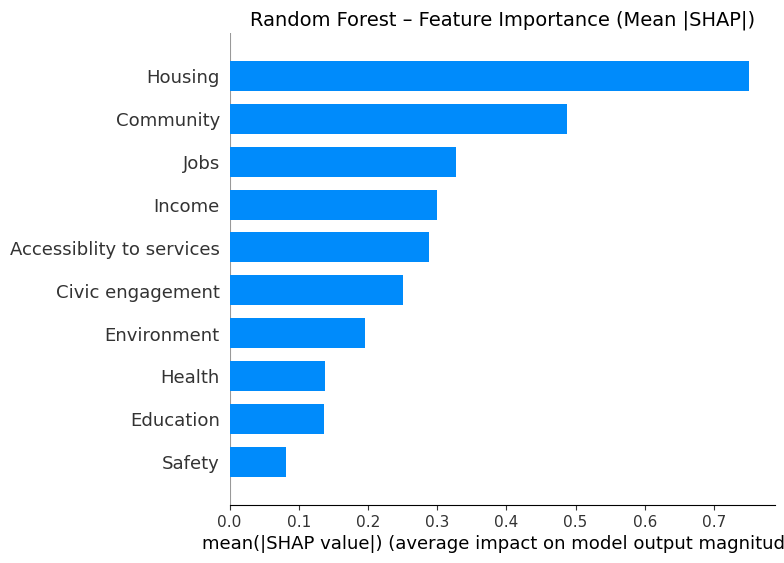

In [116]:
import matplotlib.pyplot as plt
import shap



plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_score,
    X_train_score,
    plot_type="bar",
    show=False
)
plt.title("Random Forest – Feature Importance (Mean |SHAP|)", fontsize=14)
plt.subplots_adjust(left=0.3)
plt.show()

The SHAP analysis reveals the relative importance of input features in predicting life satisfaction with the Random Forest model. Housing emerges as the most influential factor, with a mean absolute SHAP value of 0.75, indicating it has the largest average effect on the model’s output. Community, Jobs, and Income follow as key predictors, highlighting the importance of social and economic conditions. Environmental and health factors have moderate influence, while Safety and Education show the least impact in this model

### SHAP Beeswarm

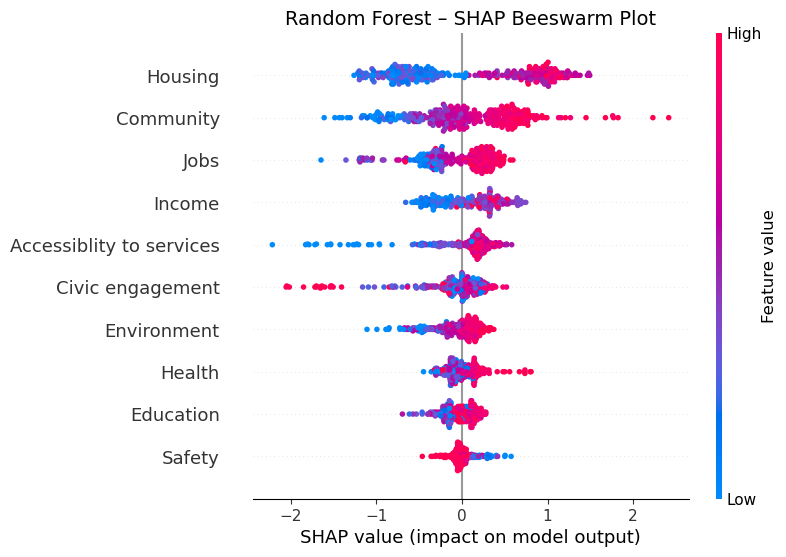

In [596]:
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_score,
    X_train_score,
    show=False
)
plt.title("Random Forest – SHAP Beeswarm Plot", fontsize=14)
plt.subplots_adjust(left=0.3)
plt.show()


Most features exhibit expected directional effects, where higher feature values (shown in red) tend to increase predicted life satisfaction (dots shifted to the right on the x-axis). However, Safety shows an opposite pattern—higher Safety values correspond to lower predicted satisfaction. This may indicate complex or confounded relationships within the data. Similarly, Civic Engagement generally has a positive impact on predictions, but some cases with high Civic Engagement are linked to lower predicted life satisfaction, suggesting potential nonlinear effects or subgroup-specific influences that deserve further exploration.

Accessibility to Services and Environment features show clusters of high values that exert a modest positive effect on life satisfaction predictions, indicated by red dots close to zero on the SHAP value axis. However, a smaller group of samples with low values in these features demonstrates stronger negative impacts, implying that poor accessibility or environmental conditions can detract from predicted satisfaction in certain cases. Education follows a similar, though less pronounced, trend—generally a mild positive influence with occasional negative effects at very low levels. Health behaves similarly but with less severe negative impact from low values.

The most balanced features appear to be Housing, Community, and Income. Notably, Income has a relatively weak effect, while Community needs to be quite high to significantly increase predictions, as shown by the cluster of purple dots near the center and slightly to the left. Housing values are distributed almost symmetrically around zero, spanning roughly one unit below and above it.

### SHAP Dependence Plots

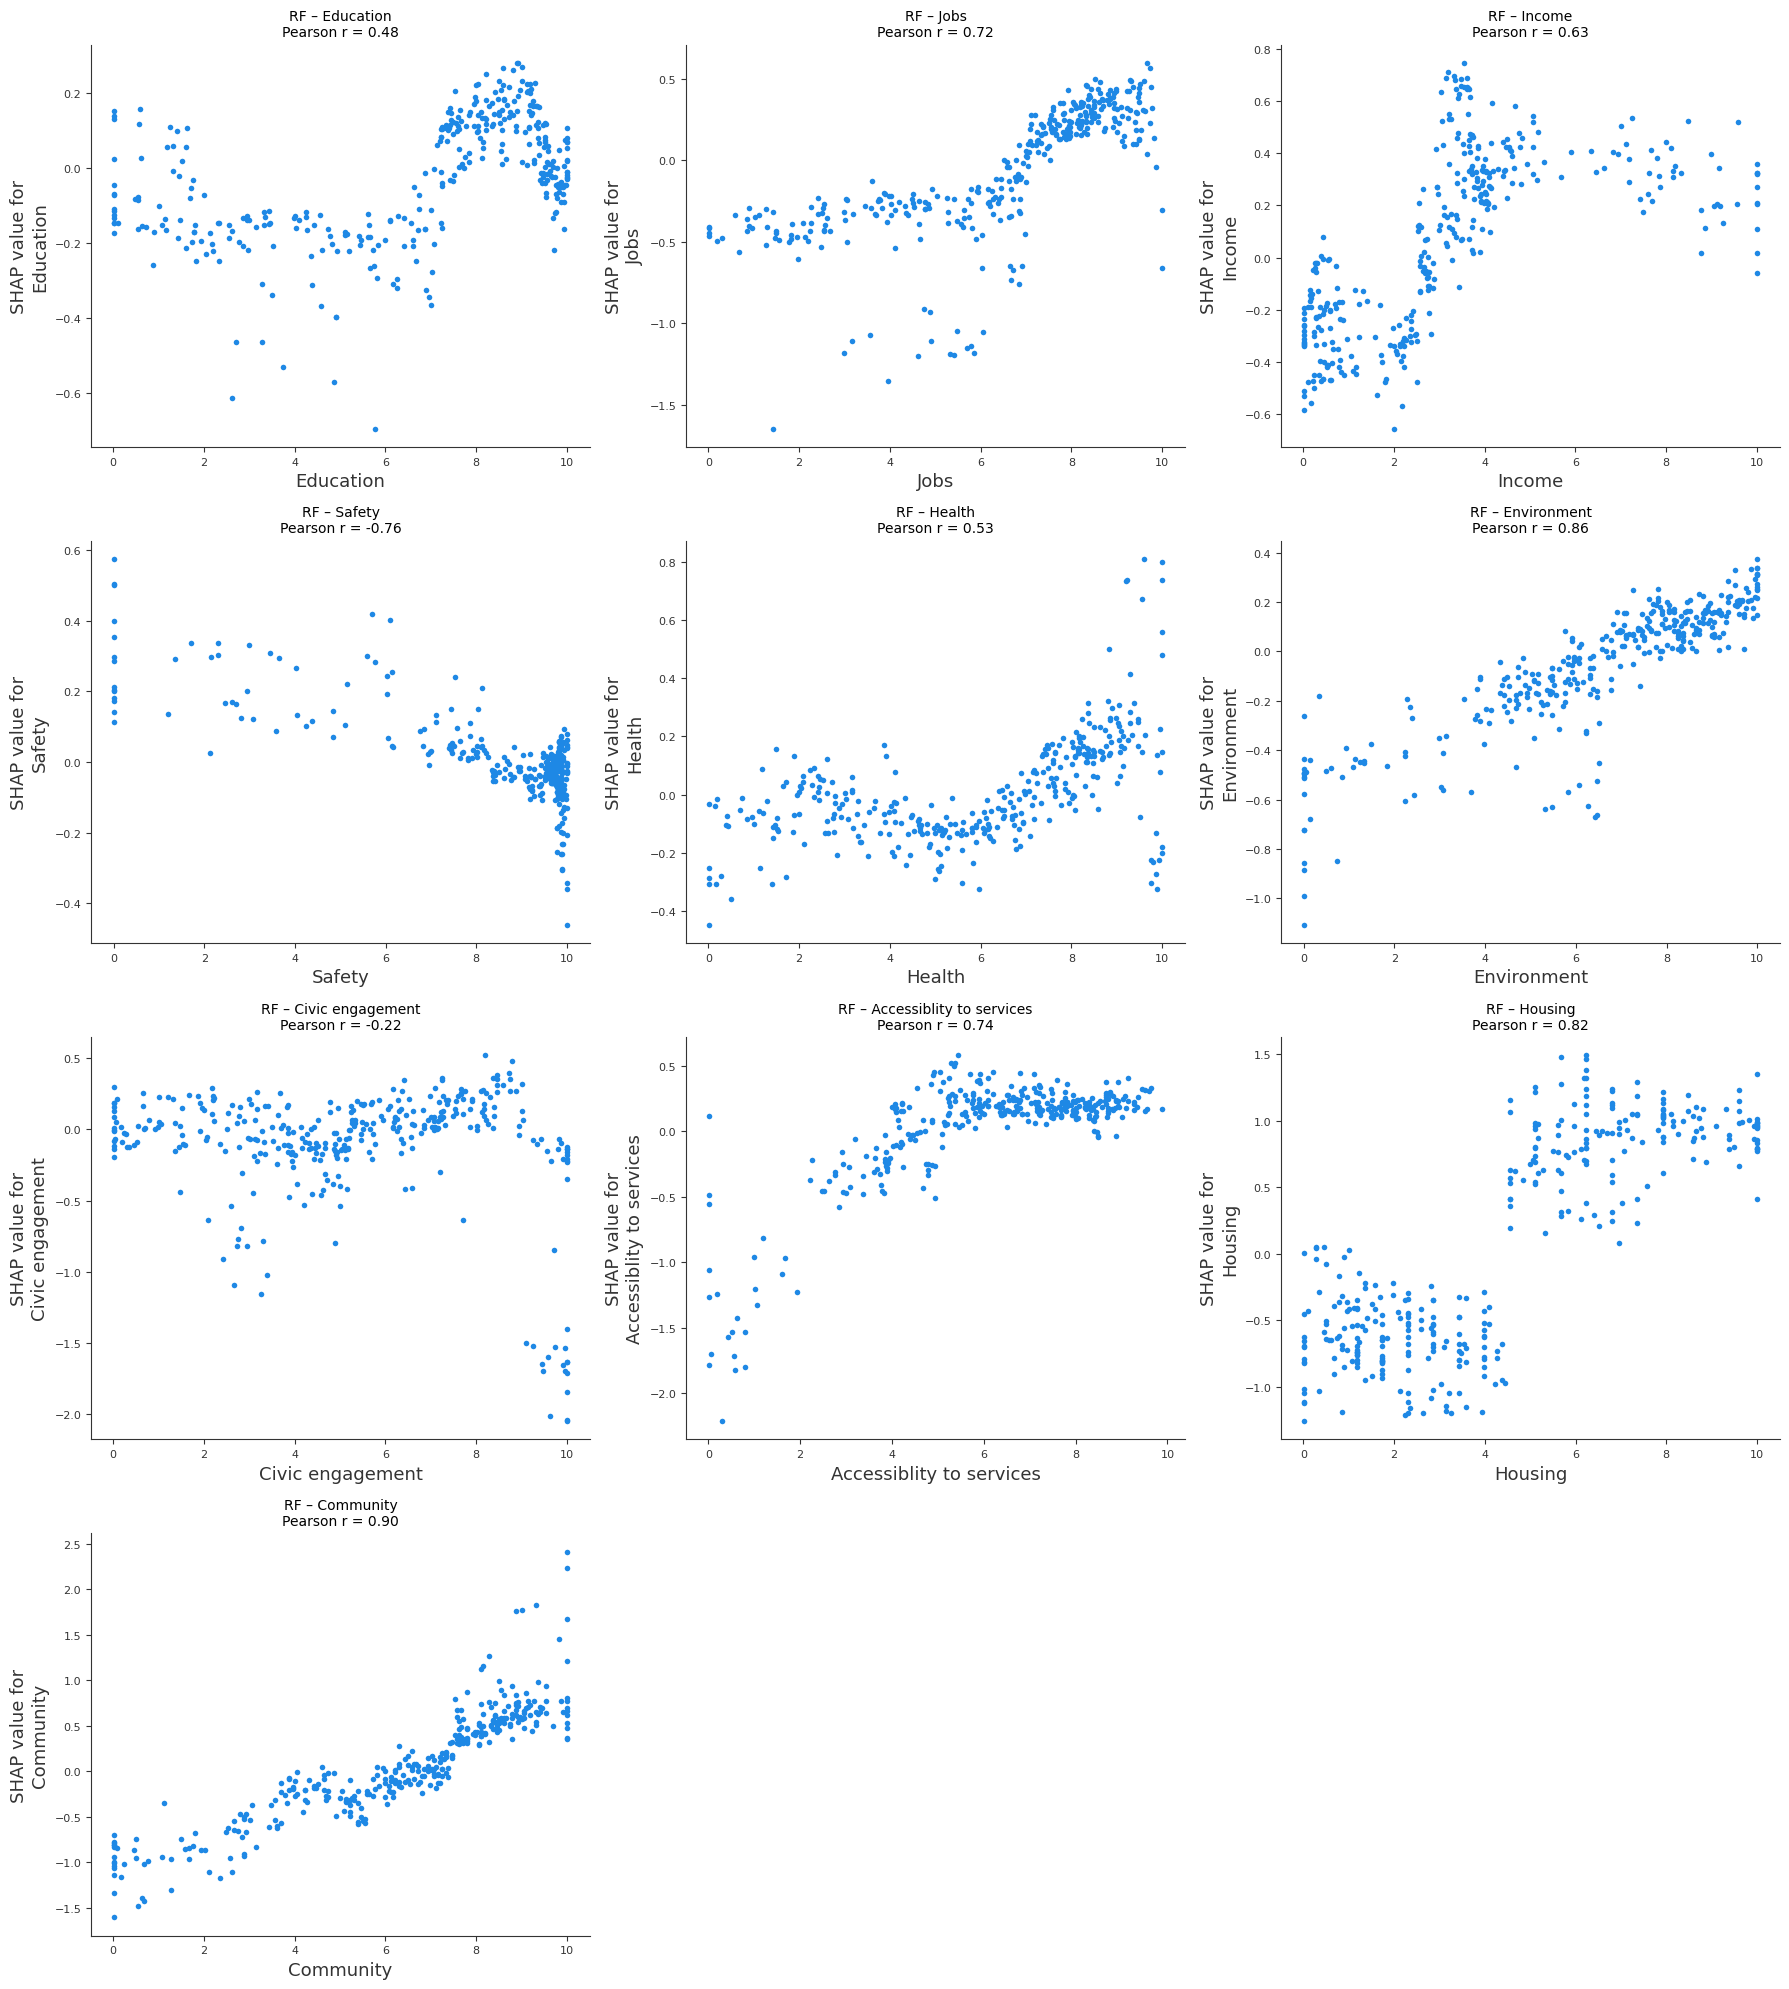

In [207]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import pandas as pd



shap_df_score = pd.DataFrame(shap_values_score, columns=X_train_score.columns)

top_features_rf = shap_summary_score.index[:10].tolist()

n_cols = 3
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(top_features_rf):
    ax = axes[i]
    
    feature_values = X_train_score[feature].values
    shap_vals = shap_df_score[feature].values
    
    valid_mask = ~pd.isna(feature_values) & ~pd.isna(shap_vals)
    corr, _ = pearsonr(feature_values[valid_mask], shap_vals[valid_mask])
    
    shap.dependence_plot(
        feature,
        shap_values_score,
        X_train_score,
        interaction_index=None,
        ax=ax,
        show=False
    )
    ax.set_title(f"RF – {feature}\nPearson r = {corr:.2f}", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

for j in range(len(top_features_rf), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


These graphs help deepen our understanding of the patterns we observed earlier and provide additional insights. Starting with Education, the score appears to improve only when values fall below or above certain thresholds (around 2 and 7), while it decreases in between. The Jobs score shows a positive correlation that strengthens at higher values—above roughly 8—while maintaining a moderate positive correlation at lower values. Income exhibits a strong positive correlation up to a score of about 4, after which the relationship levels off.

As noted before, Safety has a negative correlation, with a high concentration of points around a score of 10. Health behaves similarly to Education but less pronounced, showing a more positive impact when scores are below 3 or above 6, forming a kind of U-shaped pattern. Environment displays a fairly straightforward positive correlation. Civic Engagement, however, shows no clear correlation.

Health has a high correlation overall but seems to plateau beyond a score of 6. Community demonstrates a strong positive correlation. Lastly, Housing presents an unusual pattern: scores below 5 have a negative impact, while those above 5 show a positive effect, though no clear pattern emerges within these two clusters.

# Indicators Dataset

In [11]:
df_ind = datasets["Indicator_Last_Region"]

## NaN values handling

In [14]:
import pandas as pd



initial_rows = len(df_ind)

df_ind = df_ind.dropna(subset=["Self assessment of life satisfaction"])

dropped_rows = initial_rows - len(df_ind)
print(f"Rows dropped due to missing 'Self assessment of life satisfaction': {dropped_rows}")

columns_to_exclude = ["Country", "Region", "Code", "Self assessment of life satisfaction"]
X_ind = df_ind.drop(columns=columns_to_exclude, errors="ignore")
y_ind = df_ind["Self assessment of life satisfaction"]


Rows dropped due to missing 'Self assessment of life satisfaction': 10


## Train and Test split

In [19]:
from sklearn.model_selection import train_test_split



X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
    X_ind, y_ind, test_size=0.2, random_state=1748
)

test_indices = y_test_ind.index

## Hyperparameters Tuning

In [507]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error



models = {
    "Random Forest": RandomForestRegressor(random_state=1748, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=1748, n_jobs=-1, objective="reg:squarederror"),
}

param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [None, 10, 20, 30, 40],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [3, 4, 5, 6],
        "learning_rate": [0.01, 0.03, 0.05, 0.1],
        "subsample": [0.5, 0.7, 0.8, 1.0],
        "colsample_bytree": [0.5, 0.7, 0.8, 1.0],
        "gamma": [0, 0.1, 0.2, 0.5],
    },
}


best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        model,
        param_grid=param_grids[name],
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )
    grid_search.fit(X_train_ind, y_train_ind)
    best_models[name] = grid_search.best_estimator_

    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best CV RMSE: {-grid_search.best_score_:.3f}")

for name, model in best_models.items():
    y_pred_ind = model.predict(X_test_ind)
    test_rmse = root_mean_squared_error(y_test_ind, y_pred_ind)
    print(f"{name} Test RMSE: {test_rmse:.3f}")


Tuning Random Forest...
Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best params for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV RMSE: 0.413

Tuning XGBoost...
Fitting 5 folds for each of 5120 candidates, totalling 25600 fits
Best params for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best CV RMSE: 0.407
Random Forest Test RMSE: 0.383
XGBoost Test RMSE: 0.385


As a result we have that: 

---------------------------------------------------------------------------------------------------------------------------------------------
Best params for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
           
Best CV RMSE: 0.413

---------------------------------------------------------------------------------------------------------------------------------------------
Best params for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
           
Best CV RMSE: 0.407

---------------------------------------------------------------------------------------------------------------------------------------------
Random Forest Test RMSE: 0.383

XGBoost Test RMSE: 0.385

In [510]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error



models = {
    "Random Forest": RandomForestRegressor(random_state=1748, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=1748, n_jobs=-1, objective="reg:squarederror"),
}

param_grids = {
    "Random Forest": {
        "n_estimators": [190, 195, 200, 205, 210],
        "max_depth": [None],
        "min_samples_split": [2, 3],
        "min_samples_leaf": [1, 2],
        "bootstrap": [True],
    },
    "XGBoost": {
        "n_estimators": [490, 495, 500, 505, 510],
        "max_depth": [2, 3, 4],
        "learning_rate": [0.04, 0.05, 0.06],
        "subsample": [0.95, 1.0], 
        "colsample_bytree": [0.65, 0.7, 0.75],
        "gamma": [0, 0.05],
    }
}

best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        model,
        param_grid=param_grids[name],
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )
    grid_search.fit(X_train_ind, y_train_ind)
    best_models[name] = grid_search.best_estimator_

    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best CV RMSE: {-grid_search.best_score_:.3f}")

for name, model in best_models.items():
    y_pred_ind = model.predict(X_test_ind)
    test_rmse = root_mean_squared_error(y_test_ind, y_pred_ind)
    print(f"{name} Test RMSE: {test_rmse:.3f}")


Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 205}
Best CV RMSE: 0.413

Tuning XGBoost...
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best params for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 505, 'subsample': 1.0}
Best CV RMSE: 0.407
Random Forest Test RMSE: 0.383
XGBoost Test RMSE: 0.384


As a result we have that:

-----------------------------------------------------------------------------------------------------------------------------------------------
Best params for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 205}

Best CV RMSE: 0.413 

-----------------------------------------------------------------------------------------------------------------------------------------------
Best params for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 505, 'subsample': 1.0}

Best CV RMSE: 0.407

-----------------------------------------------------------------------------------------------------------------------------------------------
Random Forest Test RMSE: 0.383

XGBoost Test RMSE: 0.384

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor



rf_model_ind = RandomForestRegressor(
    n_estimators=205,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=1748,
    n_jobs=-1
)

rf_model_ind.fit(X_train_ind, y_train_ind)


RandomForestRegressor(n_estimators=205, n_jobs=-1, random_state=1748)

## XGBoost

In [25]:
from xgboost import XGBRegressor



xgb_model_ind = XGBRegressor(
    n_estimators=505,
    max_depth=3,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=0.7,
    gamma=0,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=1748
)

xgb_model_ind.fit(X_train_ind, y_train_ind)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=505,
             n_jobs=-1, num_parallel_tree=None, ...)

## T-test

In [28]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, make_scorer
from scipy.stats import ttest_rel
import numpy as np

rmse_scorer = make_scorer(root_mean_squared_error)

cv = KFold(n_splits=5, shuffle=True, random_state=1748)

xgb_scores = cross_val_score(xgb_model_ind, X_train_ind, y_train_ind, scoring=rmse_scorer, cv=cv)
rf_scores = cross_val_score(rf_model_ind, X_train_ind, y_train_ind, scoring=rmse_scorer, cv=cv)

print("Cross-validated RMSE:")
print(f"XGBoost: Mean = {xgb_scores.mean():.4f}, Std = {xgb_scores.std():.4f}")
print(f"Random Forest: Mean = {rf_scores.mean():.4f}, Std = {rf_scores.std():.4f}")

# Paired t-test
t_stat, p_value = ttest_rel(xgb_scores, rf_scores)
print("\nPaired t-test between XGBoost and Random Forest RMSE:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    better = "XGBoost" if xgb_scores.mean() < rf_scores.mean() else "Random Forest"
    print(f"The difference is statistically significant. {better} performs better.")
else:
    print("No statistically significant difference found.")


Cross-validated RMSE:
XGBoost: Mean = 0.4479, Std = 0.0561
Random Forest: Mean = 0.4391, Std = 0.0650

Paired t-test between XGBoost and Random Forest RMSE:
t-statistic = 1.2246, p-value = 0.2879
No statistically significant difference found.


Cross-validated RMSE:

-----------------------------------------------------------
XGBoost: Mean = 0.4479, Std = 0.0561

Random Forest: Mean = 0.4391, Std = 0.0650

-----------------------------------------------------------
Paired t-test between XGBoost and Random Forest RMSE:

t-statistic = 1.2246, p-value = 0.2879

-----------------------------------------------------------
No statistically significant difference found.

In [30]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

mae_scorer = make_scorer(mean_absolute_error)

xgb_mae_score = cross_val_score(xgb_model_ind, X_train_ind, y_train_ind, scoring=mae_scorer, cv=cv)
rf_mae_score = cross_val_score(rf_model_ind, X_train_ind, y_train_ind, scoring=mae_scorer, cv=cv)

print("Cross-validated MAE:")
print(f"XGBoost: Mean = {xgb_mae_score.mean():.4f}, Std = {xgb_mae_score.std():.4f}")
print(f"Random Forest: Mean = {rf_mae_score.mean():.4f}, Std = {rf_mae_score.std():.4f}")

t_stat_mae, p_value_mae = ttest_rel(xgb_mae_score, rf_mae_score)
print("\nPaired t-test between XGBoost and Random Forest MAE:")
print(f"t-statistic = {t_stat_mae:.4f}, p-value = {p_value_mae:.4f}")
if p_value_mae < 0.05:
    better = "XGBoost" if xgb_mae_score.mean() < rf_mae_score.mean() else "Random Forest"
    print(f"The difference is statistically significant. {better} performs better.")
else:
    print("No statistically significant difference found.")


Cross-validated MAE:
XGBoost: Mean = 0.3196, Std = 0.0190
Random Forest: Mean = 0.3004, Std = 0.0162

Paired t-test between XGBoost and Random Forest MAE:
t-statistic = 3.1282, p-value = 0.0352
The difference is statistically significant. Random Forest performs better.


Cross-validated MAE:

---------------------------------------------------------------------------------
XGBoost: Mean = 0.3196, Std = 0.0190

Random Forest: Mean = 0.3004, Std = 0.0162

---------------------------------------------------------------------------------
Paired t-test between XGBoost and Random Forest MAE:

t-statistic = 3.1282, p-value = 0.0352

---------------------------------------------------------------------------------
The difference is statistically significant. Random Forest performs better.

In [33]:
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

r2_scorer = make_scorer(r2_score)

xgb_r2_score = cross_val_score(xgb_model_ind, X_train_ind, y_train_ind, scoring=r2_scorer, cv=cv)
rf_r2_score = cross_val_score(rf_model_ind, X_train_ind, y_train_ind, scoring=r2_scorer, cv=cv)

print("\nCross-validated R²:")
print(f"XGBoost: Mean = {xgb_r2_score.mean():.4f}, Std = {xgb_r2_score.std():.4f}")
print(f"Random Forest: Mean = {rf_r2_score.mean():.4f}, Std = {rf_r2_score.std():.4f}")

t_stat_r2, p_value_r2 = ttest_rel(xgb_r2_score, rf_r2_score)
print("\nPaired t-test between XGBoost and Random Forest R²:")
print(f"t-statistic = {t_stat_r2:.4f}, p-value = {p_value_r2:.4f}")
if p_value_r2 < 0.05:
    better = "XGBoost" if xgb_r2_score.mean() > rf_r2_score.mean() else "Random Forest"
    print(f"The difference is statistically significant. {better} performs better.")
else:
    print("No statistically significant difference found.")



Cross-validated R²:
XGBoost: Mean = 0.6461, Std = 0.0459
Random Forest: Mean = 0.6585, Std = 0.0645

Paired t-test between XGBoost and Random Forest R²:
t-statistic = -1.1544, p-value = 0.3126
No statistically significant difference found.


Cross-validated R²:

----------------------------------------------------
XGBoost: Mean = 0.6461, Std = 0.0459

Random Forest: Mean = 0.6585, Std = 0.0645

----------------------------------------------------
Paired t-test between XGBoost and Random Forest R²:

t-statistic = -1.1544, p-value = 0.3126

----------------------------------------------------
No statistically significant difference found.

The only significant difference was found when looking at the mean absolute error, in favour of Random Forest. Given that and the fact that random forest performed better on the other dataset too, we chose to analyse this model also to compare the behaviour on the two different datasets.

## Plotting the predictions

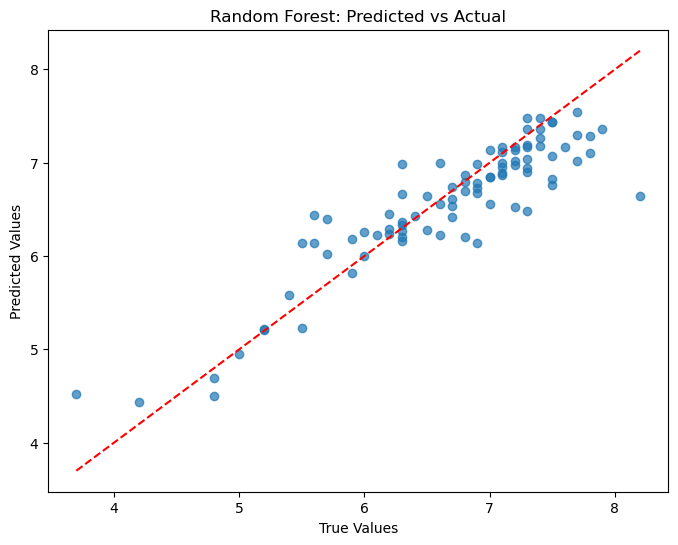

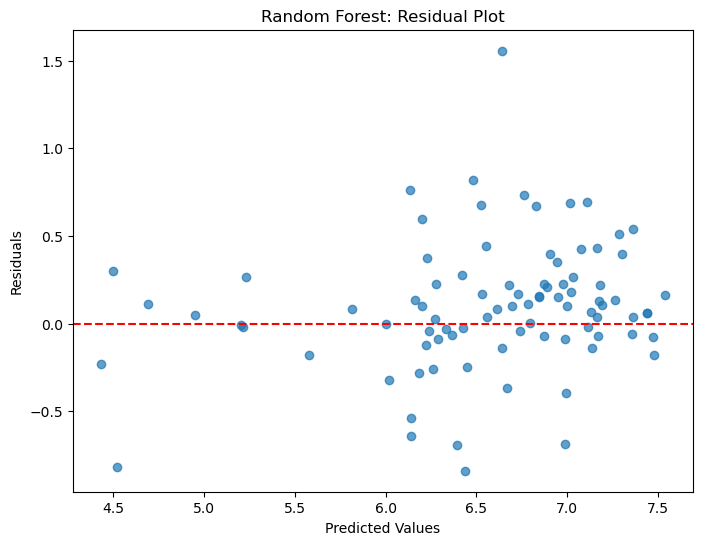

In [261]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, model_name, data, original_indices):
    residuals = y_true - y_pred
    threshold = residuals.abs().mean() + 2 * residuals.abs().std()
    outliers = residuals[residuals.abs() > threshold].index

    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.show()

    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"{model_name}: Residual Plot")
    plt.show()
    
    return outliers

rf_preds = rf_model_ind.predict(X_test_ind)
outliers = plot_predictions(
    y_true=y_test_ind.reset_index(drop=True), 
    y_pred=rf_preds, 
    model_name="Random Forest", 
    data=df_ind, 
    original_indices=test_indices
)



Residuals Summary Statistics:
count    88.000000
mean      0.096081
std       0.373185
min      -0.839512
25%      -0.069756
50%       0.091220
75%       0.235976
max       1.557073
Name: Self assessment of life satisfaction, dtype: float64


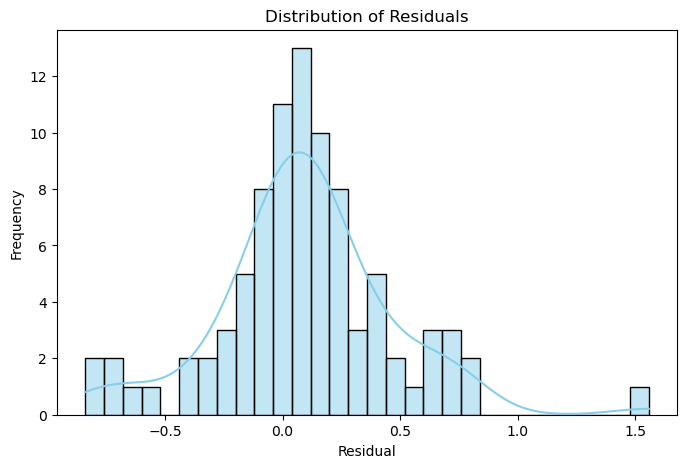

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def residuals_analysis(y_true, y_pred, data=None):
    residuals = y_true - y_pred
    
    # Basic stats
    print("Residuals Summary Statistics:")
    print(residuals.describe())
    
    # Histogram of residuals
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, bins=30, kde=True, color='skyblue')
    plt.title("Distribution of Residuals")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()


# Example usage for the 'ind' dataset
rf_preds_ind = rf_model_ind.predict(X_test_ind)
residuals_analysis(y_test_ind.reset_index(drop=True), rf_preds_ind, data=df_ind)


The residuals have a mean close to zero (0.096), indicating that on average, the model's predictions are fairly unbiased. The standard deviation is relatively small (0.37), showing most prediction errors are moderate. Residuals range from about -0.84 to 1.56, meaning some predictions under- or overestimate life satisfaction by up to around 1.5 units. Overall, errors are reasonably contained, but there are a few larger deviations on the edges.

The current model fitted ont the indicators dataset has much smaller average errors and less variability, indicating it’s more accurate and consistent in its predictions. It so appears to perform better with fewer and smaller prediction mistakes.

## SHAP analysis

### SHAP Table and Bar Chart

In [85]:
import shap
import pandas as pd



rf_explainer_ind = shap.TreeExplainer(rf_model_ind)
shap_values_ind = rf_explainer_ind.shap_values(X_train_ind)

shap_df_ind = pd.DataFrame(shap_values_ind, columns=X_train_ind.columns)
shap_summary_ind = shap_df_ind.abs().mean()

shap_table_ind = shap_summary_ind.to_frame(name="SHAP Mean")
shap_table_ind["Rank"] = shap_table_ind["SHAP Mean"].rank(ascending=False).astype(int)
shap_table_ind = shap_table_ind.sort_values("Rank")

pd.set_option("display.max_rows", None)
print("SHAP Mean Absolute Values with Rankings:\n")
print(shap_table_ind)

SHAP Mean Absolute Values with Rankings:

                                                    SHAP Mean  Rank
Perceived social network support                     0.143428     1
Number of rooms per person                           0.138554     2
Household disposable income per capita (constan...   0.106782     3
Employment rate (%)                                  0.105231     4
Voter turnout (%)                                    0.063780     5
Air pollution (level of PM2.5) (µg/m³)               0.046959     6
Broadband access (% of households)                   0.046566     7
Internet download speed 2021-Q4 (deviation from...   0.043463     8
Population with at least secondary education (%)     0.037504     9
Unemploy-ment rate (%)                               0.026737    10
Life expectancy (Number of years)                    0.024188    11
Homicide rate (per 100-000 people)                   0.021721    12
Mortality rate (per 1-000 people)                    0.012019    13


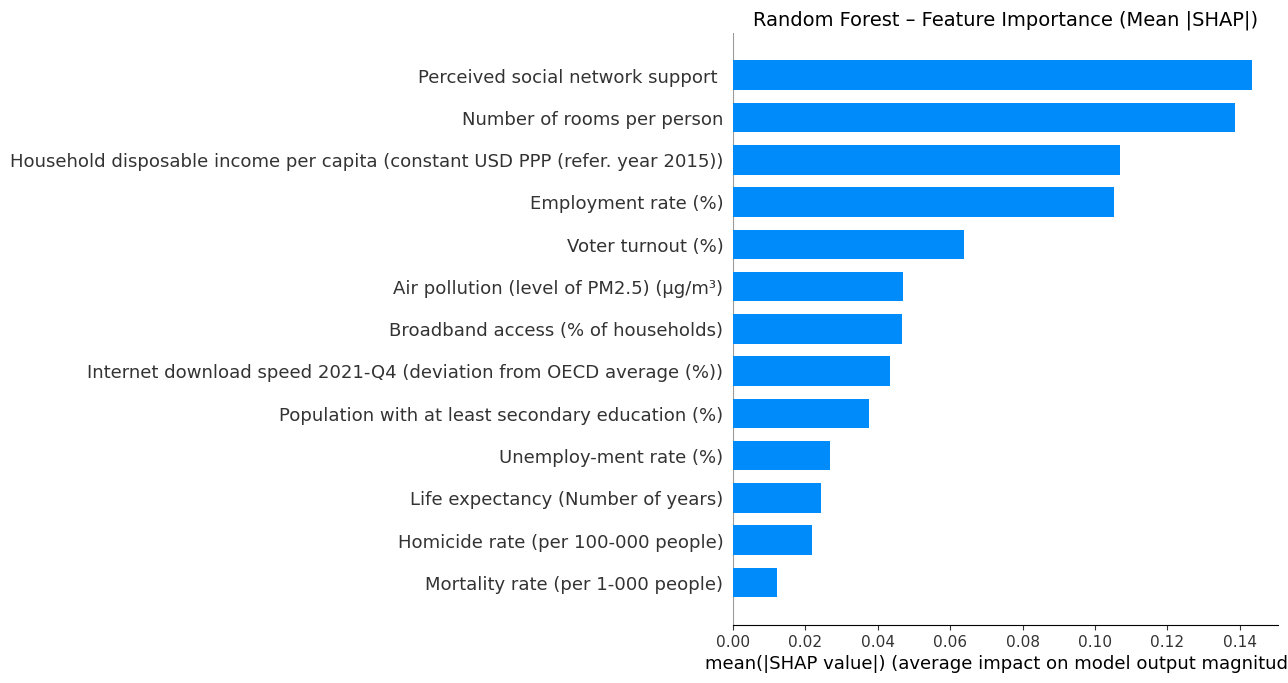

In [41]:
import matplotlib.pyplot as plt
import shap



plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_ind,
    X_train_ind,
    plot_type="bar",
    show=False
)
plt.title("Random Forest – Feature Importance (Mean |SHAP|)", fontsize=14)
plt.subplots_adjust(left=0.3)
plt.show()

In [105]:
import pandas as pd



dimension_map = pd.DataFrame({
    "Dimension": [
        "Income", "Jobs", "Jobs", "Housing", "Health", "Health", "Education", "Environment",
        "Safety", "Civic Engagement", "Accessibility of Services", "Accessibility of Services",
        "Community"
    ],
    "Indicator": [
        "Household disposable income per capita (in real USD PPP)",
        "Employment rate (%)",
        "Unemploy-ment rate (%)",
        "Number of rooms per person",
        "Life expectancy (Number of years)",
        "Mortality rate (per 1-000 people)",
        "Population with at least secondary education (%)",
        "Air pollution (level of PM2.5) (µg/m³)",
        "Homicide rate (per 100-000 people)",
        "Voter turnout (%)",
        "Broadband access (% of households)",
        "Internet download speed 2021-Q4 (deviation from OECD average)",
        "Perceived social network support"
    ]
})

ranks_ind = shap_table_ind[["Rank"]].rename(columns={"Rank": "Rank_ind"})
ranks_score = shap_table_score[["Rank"]].rename(columns={"Rank": "Rank_score"})

merged = dimension_map.merge(ranks_ind, left_on="Indicator", right_index=True, how="left")

merged = merged.merge(ranks_score, left_on="Dimension", right_index=True, how="left")

merged = merged.sort_values(["Dimension", "Rank_ind"])

merged.reset_index(drop=True, inplace=True)

print("Grouped SHAP Ranks by Dimension and Indicator:\n")
print(merged)

Grouped SHAP Ranks by Dimension and Indicator:

                    Dimension  \
0   Accessibility of Services   
1   Accessibility of Services   
2            Civic Engagement   
3                   Community   
4                   Education   
5                 Environment   
6                      Health   
7                      Health   
8                     Housing   
9                      Income   
10                       Jobs   
11                       Jobs   
12                     Safety   

                                            Indicator  Rank_ind  Rank_score  
0                  Broadband access (% of households)       7.0         NaN  
1   Internet download speed 2021-Q4 (deviation fro...       NaN         NaN  
2                                   Voter turnout (%)       5.0         NaN  
3                    Perceived social network support       NaN         2.0  
4    Population with at least secondary education (%)       9.0         9.0  
5              Air po

From the table and the chart we can already tell one thing and it is that the absolute values are much lower if compared to the ones observed in the score dataset. This is likely due to its narrower target range, which limits how much each feature can contribute to the model's prediction. But that does not really matter since what we really want is analyse these values inside the model.

The ranking shows a strong correspondence between the most influential dimensions in both models. In fact if we watch the comparison table factors like Housing, Community support, Jobs, and Income consistently rank high in both the score and indicator dataset models. Minor discrepancies like Accessibility or Health may reflect differences in the impact of aggregated versus individual indicators.

### SHAP Beeswarm

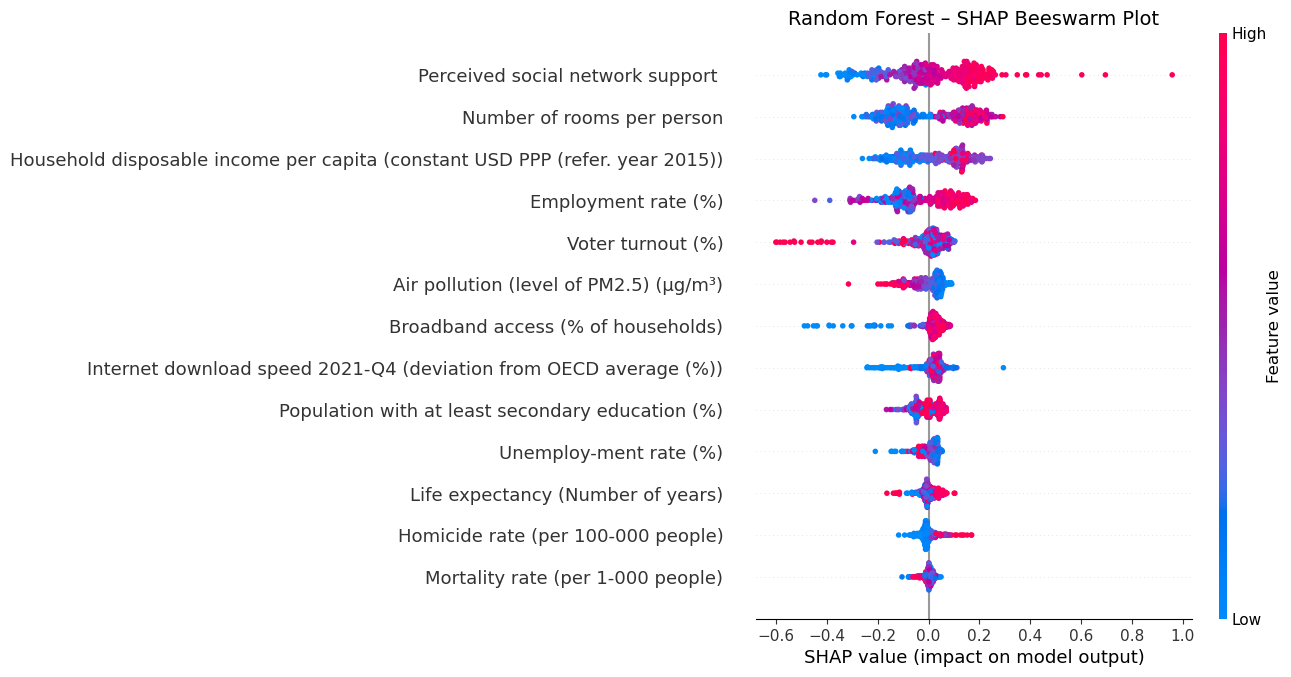

In [607]:
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_ind,
    X_train_ind,
    show=False
)
plt.title("Random Forest – SHAP Beeswarm Plot", fontsize=14)
plt.subplots_adjust(left=0.3)
plt.show()

Examining the number of rooms per person, we observe a behavior nearly identical to the housing score in the model. Similarly, perceived social network support closely mirrors the community score, and household disposable income aligns well with the income score. When looking at broadband access, it shows a similar pattern to the accessibility to services score. However, the other related indicator, internet download speed, tends to have high SHAP values even when scores are negative, as indicated by the presence of blue points on the right side. This suggests that the model may consider broadband access more influential than download speed, which makes sense since having access is a prerequisite, while speed is a secondary concern.

For employment and unemployment rates, the model indicates that employment rate carries more importance in predicting the target variable. Unlike the combined jobs indicator in the score model, these two are treated separately here and show inverse trends: higher employment corresponds to higher SHAP values, whereas higher unemployment relates to lower SHAP values. Nevertheless, some blue points appear on the left side for unemployment and red points on the employment side, a pattern also seen in the score model.

Regarding voter turnout, which corresponds to civic engagement, the values are more clustered around the center compared to the score model but still exhibit similar behavior. The same applies to the population with at least secondary education and the education score. Air pollution and environment indicators show nearly identical patterns but with opposite trends due to their inherent meanings. A similar relationship exists between homicide rate and safety.

Finally, looking at life expectancy and mortality rate, we see the expected opposite trends, though the separation is not very clear, with some blue points on the left for mortality and red points on the right for expectancy. This ambiguity is also present in the health score of the first model.

### SHAP Dependence Plots

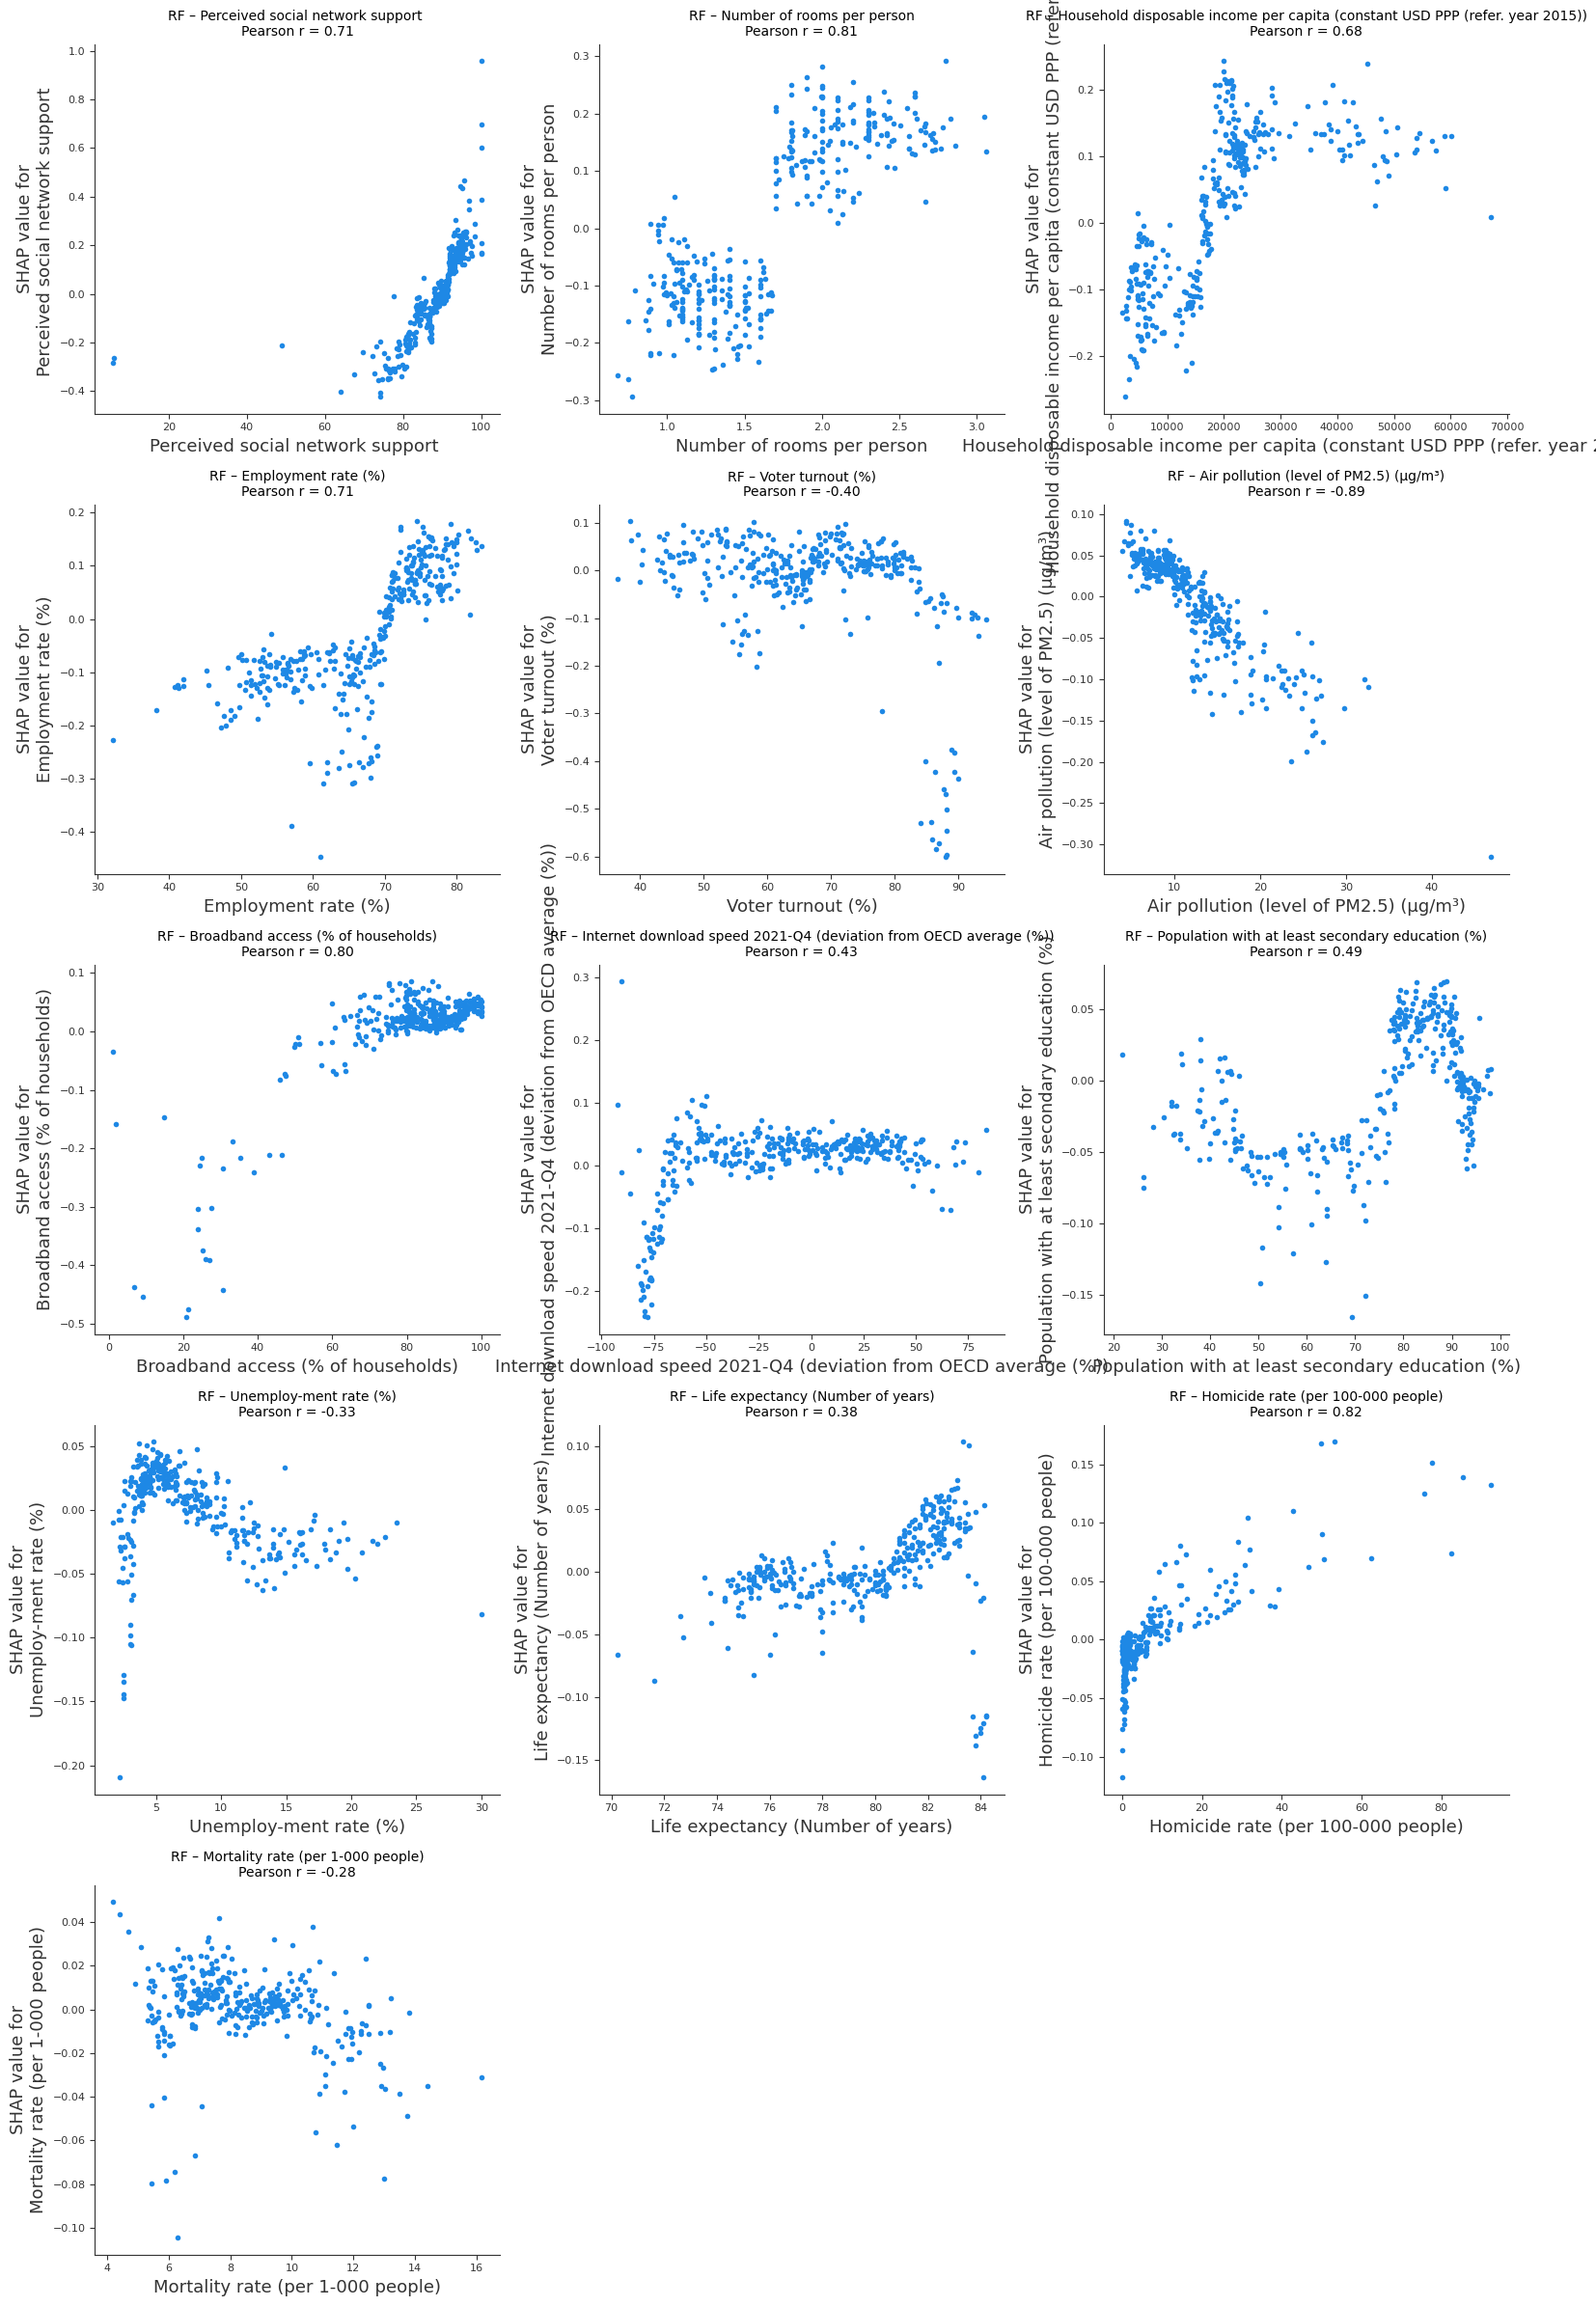

In [130]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import pandas as pd

shap_df_ind = pd.DataFrame(shap_values_ind, columns=X_train_ind.columns)
shap_summary_ind = shap_df_ind.abs().mean()
top_features_rf = shap_summary_ind.sort_values(ascending=False).head(13).index.tolist()

n_cols = 3
n_rows = int(np.ceil(len(top_features_rf) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 24))
axes = axes.flatten()

for i, feature in enumerate(top_features_rf):
    ax = axes[i]
    feature_values = X_train_ind[feature].values
    shap_vals = shap_df_ind[feature].values
    valid_mask = ~np.isnan(feature_values) & ~np.isnan(shap_vals)
    corr, _ = pearsonr(feature_values[valid_mask], shap_vals[valid_mask])
    shap.dependence_plot(
        feature,
        shap_values_ind,
        X_train_ind,
        interaction_index=None,
        ax=ax,
        show=False
    )
    ax.set_title(f"RF – {feature}\nPearson r = {corr:.2f}", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

for j in range(len(top_features_rf), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Looking at these graphs, we can draw several interesting insights on the similarities and differences between the two models. First, we notice a clear alignment between population with secondary education and the education score: life satisfaction appears to increase when values are either below 30% or above 70%, while it tends to decrease in between. A similar pattern emerges for the employment rate and the jobs score, where a notable increase in life satisfaction occurs after the employment rate surpasses 70%. For unemployment, as expected, the graph shows a generally negative trend—although some unexpected SHAP values appear even at near-zero unemployment levels.

We observe the same trend correspondence for household disposable income and the income score. Conversely, homicide rate and safety show matching but opposite trends, as expected.

The life expectancy graph here appears less sparse than the health score graph in the previous model, while still showing a positive correlation. On the other hand, mortality rate displays a weaker, but still negative, correlation—again aligning with expectations.

Regarding air pollution, we observe a strong negative correlation, similar in strength (but opposite in direction) to the positive trend seen with the environment score in the first model. The voter turnout correlation here leans more negative compared to the corresponding civic engagement score, a difference also reflected in their correlation coefficients.

Looking at broadband access, we find that most values are high (above 70%) and show a strong positive correlation with SHAP values. In contrast, internet download speed has more distributed values and seems to hit a cap—SHAP values increase strongly until around -50, after which they flatten. This behavior is mirrored in the accessibility to services score graph, which captures both the generally high values and this plateau effect.

The number of rooms feature behaves very similarly to what we saw with the housing score. Finally, perceived social network support shows a strong positive correlation, closely matching the community score graph from the first model—though here, the values are mostly concentrated above 60%.

The comparison between the two models shows that the detailed indicators closely reflect the broader dimension scores, confirming that the underlying factors driving life satisfaction are consistent across scales. Differences in SHAP value magnitudes and trends highlight how specific indicators can provide nuanced insights—for example, broadband access being more influential than download speed, or employment rate carrying more weight than unemployment rate when considered separately. Overall, the analysis reinforces the validity of the dimension-level scores while also demonstrating the added value of examining individual indicators to better understand the drivers of life satisfaction.

# Policy Simulation

Policy simulation using our Random Forest model combined with SHAP values provides a powerful way to interpret how different factors influence predictions of life satisfaction. By adjusting input features and observing changes in model output and feature importance, policymakers can explore potential impacts of various interventions.

While our model has limitations and should not be viewed as a definitive decision-making tool, we believe it offers a strong baseline framework. It demonstrates the potential for future development of data-driven tools to assist governments in understanding and improving population well-being.

The model trained on the score dataset offers a broad, general overview of key dimensions affecting life satisfaction, while the indicator dataset model provides concrete parameter values, enabling more precise adjustments and targeted policy simulations.


## Scores


* Housing
* Income
* Accessiblity to services
* Jobs
* Civic engagement
* Education
* Community
* Environment
* Safety
* Health


Base prediction (median case): 5.86

SHAP values (base case):
                    Feature  SHAP Value
8                   Housing   -0.869572
2                    Income    0.355468
7  Accessiblity to services    0.290137
1                      Jobs    0.157827
5               Environment    0.125182
6          Civic engagement   -0.101748
0                 Education    0.097566
9                 Community    0.067619
3                    Safety   -0.027764
4                    Health   -0.021245


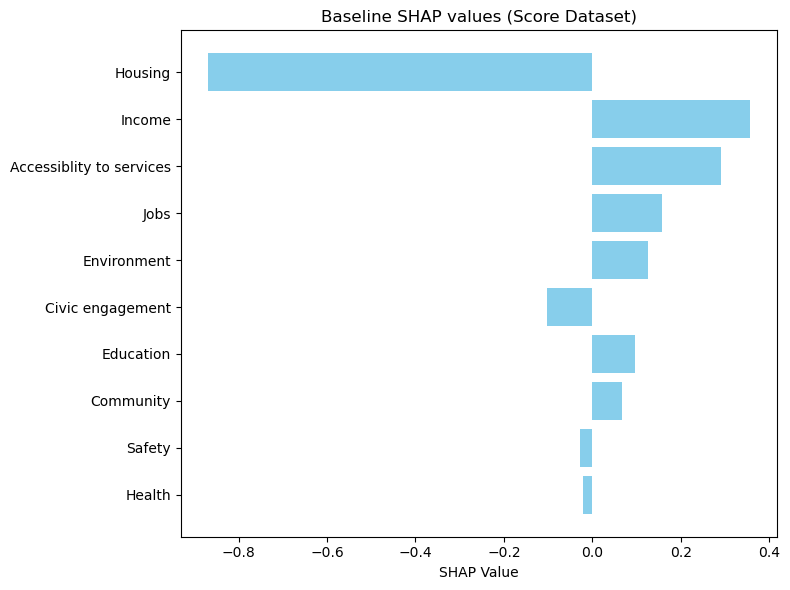

In [136]:
import shap, pandas as pd, matplotlib.pyplot as plt

sample = X_train_score.median().to_frame().T.reset_index(drop=True)

explainer = shap.TreeExplainer(rf_model_score)

base_pred = rf_model_score.predict(sample)[0]
base_shap = explainer.shap_values(sample)[0]

print(f"Base prediction (median case): {base_pred:.2f}")

base_df = (pd.DataFrame({'Feature': X_train_score.columns,
                         'SHAP Value': base_shap})
           .sort_values('SHAP Value', key=abs, ascending=False))

print("\nSHAP values (base case):")
print(base_df)

plt.figure(figsize=(8, 6))
plt.barh(base_df['Feature'], base_df['SHAP Value'], color='skyblue')
plt.xlabel('SHAP Value')
plt.title('Baseline SHAP values (Score Dataset)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



After increasing 'Housing' by 30%
    • original value: 4.10
    • new value     : 5.33
    • prediction    : 7.46

SHAP values (after change):
                    Feature  SHAP Value
8                   Housing    0.937652
2                    Income    0.443474
7  Accessiblity to services    0.191963
1                      Jobs    0.162695
6          Civic engagement   -0.140387
0                 Education    0.128636
9                 Community   -0.087921
5               Environment    0.041354
3                    Safety   -0.016290
4                    Health    0.011344


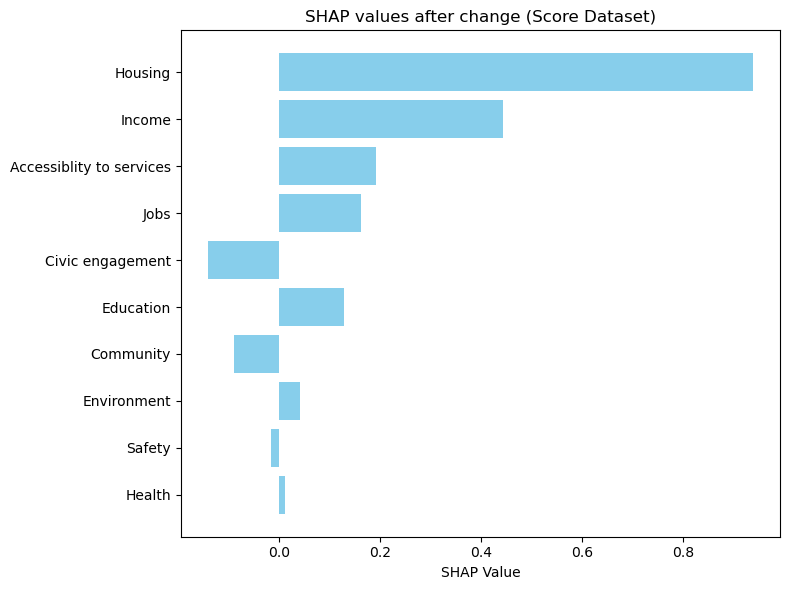

In [140]:
# ==== EDIT THESE TWO LINES EACH TIME ===
feature_to_change = 'Housing'   # Change to desired feature in score dataset
percent_increase  = 30                    
# =======================================

modified_sample = sample.copy()

orig_val = modified_sample.at[0, feature_to_change]
factor   = 1 + percent_increase / 100
modified_sample.at[0, feature_to_change] = orig_val * factor

new_pred = rf_model_score.predict(modified_sample)[0]
new_shap = explainer.shap_values(modified_sample)[0]

print(f"\nAfter increasing '{feature_to_change}' by {percent_increase}%")
print(f"    • original value: {orig_val:.2f}")
print(f"    • new value     : {modified_sample.at[0, feature_to_change]:.2f}")
print(f"    • prediction    : {new_pred:.2f}")

new_df = (pd.DataFrame({'Feature': X_train_score.columns,
                        'SHAP Value': new_shap})
          .sort_values('SHAP Value', key=abs, ascending=False))

print("\nSHAP values (after change):")
print(new_df)

plt.figure(figsize=(8,6))
plt.barh(new_df['Feature'], new_df['SHAP Value'], color='skyblue')
plt.xlabel('SHAP Value')
plt.title('SHAP values after change (Score Dataset)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Indicators

- Population with at least secondary education (%)
- Employment rate (%)
- Unemploy-ment rate (%)
- Household disposable income per capita (constant USD PPP (refer. year 2015))
- Homicide rate (per 100-000 people)
- Mortality rate (per 1-000 people)
- Life expectancy (Number of years)
- Air pollution (level of PM2.5) (µg/m³)
- Voter turnout (%)
- Broadband access (% of households)
- Internet download speed 2021-Q4 (deviation from OECD average (%))
- Number of rooms per person
- Perceived social network support


Base prediction (median case): 6.49

SHAP values (base case):
                                              Feature  SHAP Value
1                                 Employment rate (%)   -0.122378
11                         Number of rooms per person   -0.117860
3   Household disposable income per capita (consta...    0.083939
10  Internet download speed 2021-Q4 (deviation fro...    0.037041
9                  Broadband access (% of households)    0.032842
0    Population with at least secondary education (%)    0.029994
2                              Unemploy-ment rate (%)    0.024868
7              Air pollution (level of PM2.5) (µg/m³)    0.022736
12                  Perceived social network support     0.016484
4                  Homicide rate (per 100-000 people)   -0.012119
8                                   Voter turnout (%)   -0.008750
5                   Mortality rate (per 1-000 people)    0.006910
6                   Life expectancy (Number of years)   -0.001674


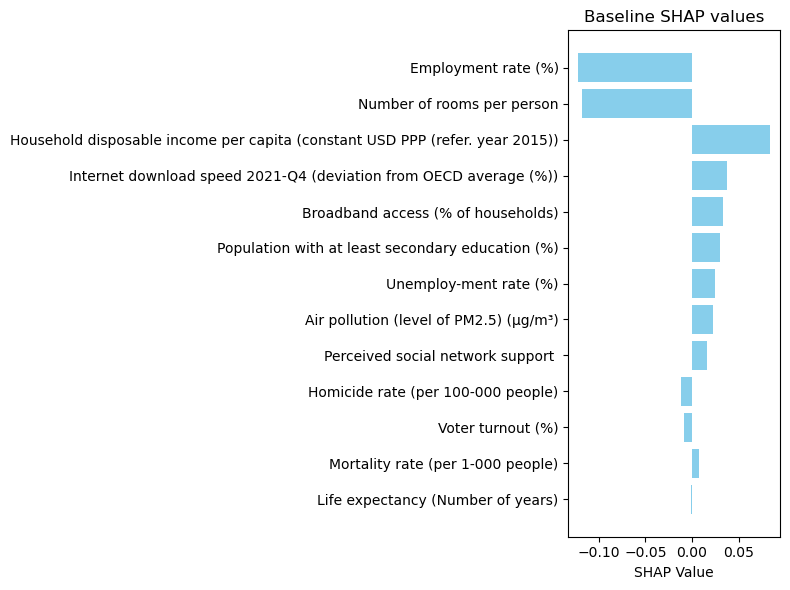

In [142]:
import shap, pandas as pd, matplotlib.pyplot as plt



sample = X_train_ind.median().to_frame().T.reset_index(drop=True)

explainer = shap.TreeExplainer(rf_model_ind)

base_pred  = rf_model_ind.predict(sample)[0]
base_shap  = explainer.shap_values(sample)[0]

print(f"Base prediction (median case): {base_pred:.2f}")

base_df = (pd.DataFrame({'Feature': X_train_ind.columns,
                         'SHAP Value': base_shap})
           .sort_values('SHAP Value', key=abs, ascending=False))
print("\nSHAP values (base case):")
print(base_df)

plt.figure(figsize=(8,6))
plt.barh(base_df['Feature'], base_df['SHAP Value'], color='skyblue')
plt.xlabel('SHAP Value'); plt.title('Baseline SHAP values')
plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()



After increasing 'Number of rooms per person' by 30%
    • original value: 1.62
    • new value     : 2.11
    • prediction    : 6.64

SHAP values (after change):
                                              Feature  SHAP Value
1                                 Employment rate (%)   -0.202447
11                         Number of rooms per person    0.140707
3   Household disposable income per capita (consta...    0.084532
0    Population with at least secondary education (%)    0.034461
2                              Unemploy-ment rate (%)    0.031530
10  Internet download speed 2021-Q4 (deviation fro...    0.028660
8                                   Voter turnout (%)   -0.023028
9                  Broadband access (% of households)    0.018459
12                  Perceived social network support     0.013397
7              Air pollution (level of PM2.5) (µg/m³)    0.011269
5                   Mortality rate (per 1-000 people)    0.007206
4                  Homicide rate (per 100-00

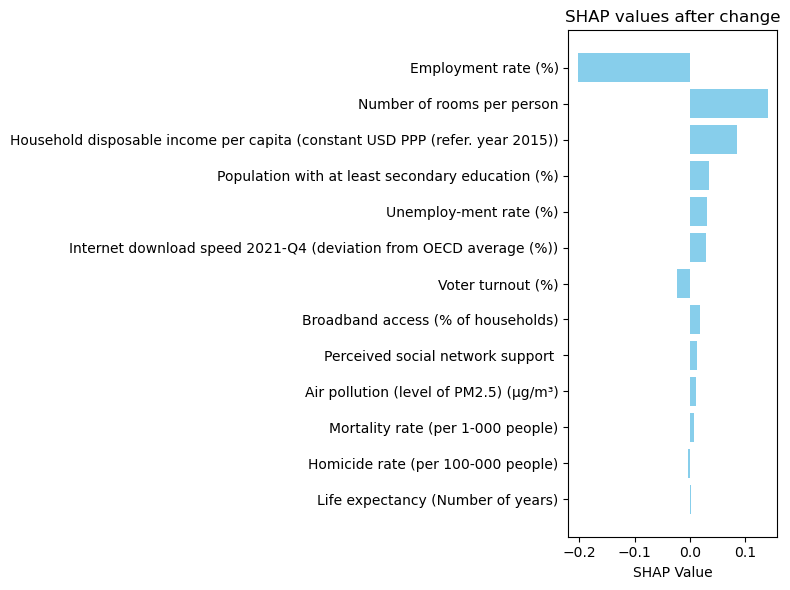

In [144]:
# ==== EDIT THESE TWO LINES EACH TIME ===
feature_to_change = 'Number of rooms per person'   
percent_increase  = 30                    
# =======================================

modified_sample = sample.copy()

orig_val = modified_sample.at[0, feature_to_change]
factor   = 1 + percent_increase/100
modified_sample.at[0, feature_to_change] = orig_val * factor

new_pred  = rf_model_ind.predict(modified_sample)[0]
new_shap  = explainer.shap_values(modified_sample)[0]

print(f"\nAfter increasing '{feature_to_change}' by {percent_increase}%")
print(f"    • original value: {orig_val:.2f}")
print(f"    • new value     : {modified_sample.at[0, feature_to_change]:.2f}")
print(f"    • prediction    : {new_pred:.2f}")

new_df = (pd.DataFrame({'Feature': X_train_ind.columns,
                        'SHAP Value': new_shap})
          .sort_values('SHAP Value', key=abs, ascending=False))

print("\nSHAP values (after change):")
print(new_df)

plt.figure(figsize=(8,6))
plt.barh(new_df['Feature'], new_df['SHAP Value'], color='skyblue')
plt.xlabel('SHAP Value'); plt.title('SHAP values after change')
plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()


# Table

| **Dimension**                 | **Indicator**                                                                 |
| ----------------------------- | ----------------------------------------------------------------------------- |
| **Income**                    | Household disposable income per capita (in real USD PPP)                      |
| **Jobs**                      | Employment rate (%)                                                           |
|                               | Unemployment rate (%)                                                         |
| **Housing**                   | Number of rooms per person (ratio)                                            |
| **Health**                    | Life expectancy at birth (years)                                              |
|                               | Age-adjusted mortality rate (per 1,000 people)                                |
| **Education**                 | Share of labour force with at least secondary education (%)                   |
| **Environment**               | Estimated average exposure to air pollution in PM2.5 (µg/m³)                  |
| **Safety**                    | Homicide rate (per 100,000 people)                                            |
| **Civic Engagement**          | Voter turnout (%)                                                             |
| **Accessibility of Services** | Share of households with broadband access (%)                                 |
|                               | Internet download speed: deviation from OECD average (%)                      |
| **Community**                 | Percentage of people who have friends or relatives to rely on in case of need |
| **Life Satisfaction**         | Average self-evaluation of life satisfaction on a scale from 0 to 10          |
